In [52]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [172]:
start = '2018-01-01'
end = '2023-08-10'

stocks = ['SPY']
indices = ['VTI', 'DBC', '^VIX', 'AGG']
index_types = ['stocks', 'commodities', 'vol_index', 'bonds']

prices = yf.download(stocks, start, end)['Close']
indices = yf.download(indices, start, end)['Close']
indices = indices.rename(columns={i: t for i, t in zip(indices, index_types)})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed


In [173]:
# Function to calculate RSI
def rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

In [174]:
lookback = 60

returns = np.log(prices).diff() * 252
volatility = prices.pct_change().rolling(lookback).std() * np.sqrt(252)
rsi_ = rsi(prices, lookback)
roc = prices.pct_change(lookback)

returns.name = 'returns'
volatility.name = 'volatility'
rsi_.name = 'rsi'
roc.name = 'roc'

stock_factors = pd.concat([returns, volatility, rsi_, roc], axis=1).dropna()
factors = indices.loc[stock_factors.index]
factors = pd.concat([stock_factors, factors], axis=1)
factors

,returns,volatility,rsi,roc,stocks,commodities,vol_index,bonds
Date,,,,,,,,
2018-03-29,3.199561,0.201453,48.084528,-0.020910,107.250000,16.980000,135.720001,19.969999
2018-04-02,-5.498886,0.205626,45.686222,-0.048064,106.900002,16.750000,132.630005,23.620001
2018-04-03,3.209355,0.207260,46.453809,-0.039910,106.779999,16.840000,134.279999,21.100000
2018-04-04,2.681856,0.208027,46.794950,-0.036062,106.820000,16.770000,135.789993,20.059999
2018-04-05,1.980979,0.208690,47.335908,-0.030228,106.669998,16.850000,136.740005,18.940001
...,...,...,...,...,...,...,...,...
2023-08-03,-0.723233,0.103857,62.881793,0.087464,95.889999,24.410000,223.850006,15.920000
2023-08-04,-1.142322,0.103890,62.783218,0.087314,96.680000,24.450001,222.899994,17.100000
2023-08-07,2.190045,0.104762,63.300983,0.091704,96.699997,24.459999,224.610001,15.770000


In [175]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(factors, test_size=0.2, shuffle=False)

scaler = StandardScaler()
hmm = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000)

pipeline = Pipeline([
    ('scaler', scaler),
    ('hmm', hmm)
])

pipeline.fit(X_train)
hidden_states_ = pipeline.predict(X_train)

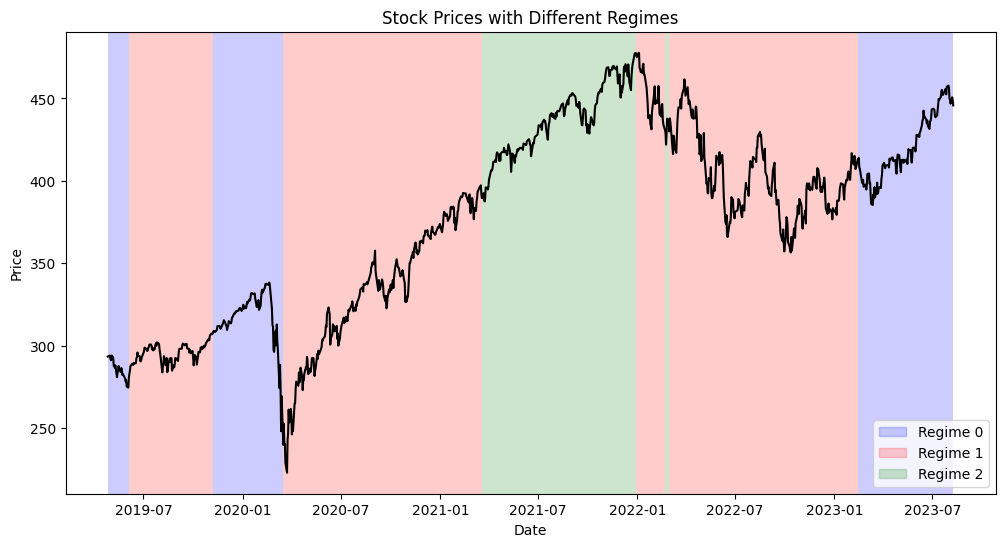

In [176]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming 'prices' contains the price data and 'hidden_states_' contains the regimes
regimes = pd.DataFrame(prices.iloc[-len(hidden_states_):].copy())
regimes['regime'] = hidden_states_

colors = ['blue', 'red', 'green']
alpha_value = 0.2

plt.figure(figsize=(12, 6))
plt.plot(regimes['Close'], color='black')
start_idx = 0
for idx in range(1, len(regimes['regime'])):
    if regimes['regime'].iloc[idx] != regimes['regime'].iloc[start_idx]:
        plt.axvspan(regimes.index[start_idx], regimes.index[idx], facecolor=colors[regimes['regime'].iloc[start_idx]], alpha=alpha_value)
        start_idx = idx
plt.axvspan(regimes.index[start_idx], regimes.index[-1], facecolor=colors[regimes['regime'].iloc[start_idx]], alpha=alpha_value)

handles = [mpatches.Patch(color=color, alpha=alpha_value, label=f'Regime {i}') for i, color in enumerate(colors)]
plt.title('Stock Prices with Different Regimes')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(handles=handles)
plt.show()

In [179]:
factors_regime = X_train.copy()
factors_regime['regime'] = hidden_states_
factors_regime.groupby('regime').mean()

,returns,volatility,rsi,roc,stocks,commodities,vol_index,bonds
regime,,,,,,,,
0,-0.230992,0.212538,44.774539,-0.062831,105.683432,21.415932,175.356356,23.620127
1,0.203864,0.125665,58.092704,0.055814,112.127574,17.141851,180.665490,16.675677
2,0.091786,0.325411,53.095551,0.029467,117.338209,12.596269,160.295622,32.606318


In [134]:
regimes

Date
2019-04-26 00:00:00                                           293.410004
2019-04-29 00:00:00                                           293.869995
2019-04-30 00:00:00                                           294.019989
2019-05-01 00:00:00                                           291.809998
2019-05-02 00:00:00                                           291.179993
                                             ...                        
2023-08-04 00:00:00                                           446.809998
2023-08-07 00:00:00                                           450.709991
2023-08-08 00:00:00                                               448.75
2023-08-09 00:00:00                                               445.75
regime                 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...
Name: Close, Length: 1081, dtype: object